# Example calculations with scalar quantities

## Objectives

To demonstrate basic calculations using scalar fields (e.g., SSH, T, S) from the state estimate including: time series of mean quantities, spatial patterns of mean quantities, spatial patterns of linear trends, and spatial patterns of linear trends over different time periods.

## Introduction

We will demonstrate global calculations with SSH (global mean sea level time series, mean dynamic topography, global mean sea level trend) and a regional calculation with THETA (nino 3.4 index).

## Global calculations with SSH

First, load all 13 tiles for sea surface height and the model grid parameters and merge the two `Datasets`.

In [1]:
import numpy as np
import sys
import xarray as xr
from copy import deepcopy 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Import the ecco_v4_py library into Python
## =========================================

## -- For the ECCO Summer School, use 
import ecco_v4_py as ecco

## -- If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.  For example, if your ecco_v4_py
##    files are in /Users/ifenty/ECCOv4-py/ecco_v4_py, then use:

# sys.path.append('/Users/ifenty/ECCOv4-py')
# import ecco_v4_py as ecco

In [8]:
## Tell Python where to find some ECCO NetCDF 
## yearly-aggregated fields (Format 1)
## ===================================

## -- For the ECCO Summer School, use
base_dir = '/work/projects/aci/ECCO/community/ECCO/ECCOv4/Release3p1'

## -- If files are on a local machine, use something like 
# base_dir = '/Users/ifenty/'

ECCO_dir = base_dir + '/eccov4r3_native_grid_netcdf/'

In [11]:
## Load the model grid
grid_dir= ECCO_dir + '/grid/'

ecco_grid = xr.open_dataset(grid_dir + 'ECCOv4r3_grid.nc')

## Load one year of 2D daily data, SSH, SST, and SSS 
day_mean_dir= ECCO_dir + 'day_mean/'

ecco_vars = ecco.recursive_load_ecco_var_from_years_nc(day_mean_dir, \
                                           vars_to_load=['SSH','THETA'], \
                                           years_to_load='all')

## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_ds = xr.merge((ecco_grid , ecco_vars))                                      

searching /Users/ifenty//eccov4r3_native_grid_netcdf/day_mean/ for variables ... 
found  ['ETAN', 'OBP', 'PHIBOT', 'SALT', 'SIarea', 'SIheff', 'SIhsnow', 'SSH', 'THETA', 'sIceLoad'] 

finished searching for SSH ... success!
finished searching for THETA ... success!


## Sea surface height

### Global mean sea level

Global mean sea surface height at time $t$ is defined as follows:

$$SSH_{\text{global mean}}(t) = \frac{\sum_{i} SSH(i,t) \,\, A(i)}{A_{\text{global ocean}}}$$

$$A_{\text{global ocean}} = \sum_{i} A(i)$$

Where $SSH(i,t)$ is dynamic height at model grid cell $i$ and time $t$, $A(i)$ is the area (m^2) of model grid cell $i$

There are several ways of doing the above calculations.  Since this is the first tutorial with actual calcuations, we'll present a few different approaches for getting to the same answer.

#### Part 1: $A_{\text{global ocean}}$

Let's start on the simplest quantity, the global ocean surface area $A_{\text{global ocean}}$.  Our calculation uses *SSH* which is a 'c' point variable.  The surface area of tracer grid cells is provided by the model grid parameter *rA*.  *rA* is a two-dimensional field that is defined over all model grid points, including land.  

To calculate the total ocean surface area we need to ignore the area contributions from land. 

We will first construct a 3D mask that is True for model grid cells that are wet and False for model grid cells that are dry cells.  

In [12]:
# ocean_mask is ceiling of hFacC which is 0 for 100% dry cells and
# 0 > hFacC >= 1 for grid cells that are at least partially wet
# hFacC is the fraction of the thickness (h) of the grid cell which
# is wet.  we'll consider all hFacC > 0 as being a wet grid cell
# and so we use the 'ceiling' function to make all values > 0 equal to
1.
ocean_mask = np.ceil(ecco_ds.hFacC)
ocean_mask.shape

(50, 13, 90, 90)

In [13]:
# the resulting ocean_mask variable is a DataArray
ocean_mask

<xarray.DataArray 'hFacC' (k: 50, tile: 13, j: 90, i: 90)>
array([[[[0., ..., 0.],
         ...,
         [1., ..., 1.]],

        ...,

        [[1., ..., 0.],
         ...,
         [1., ..., 0.]]],


       ...,


       [[[0., ..., 0.],
         ...,
         [0., ..., 0.]],

        ...,

        [[0., ..., 0.],
         ...,
         [0., ..., 0.]]]], dtype=float32)
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (tile, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    YC       (tile, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    Z        (k) float32 ...
    Depth    (tile, j, i) float32 ...
    rA       (tile, j, i) float32 dask.array<shape=(13, 90, 90), chunksi

Because this ecco_ds.hFacC varies with depth, $ocean_mask$ is three-dimensional.

To illustrate the depth dependence of $depth$ on the ocean masks we show the model wet points for Z=5m (k=0) and Z=1634m (k=35) 

In [14]:
ocean_mask[0,:].shape
ecco_ds.YC.shape

(13, 90, 90)

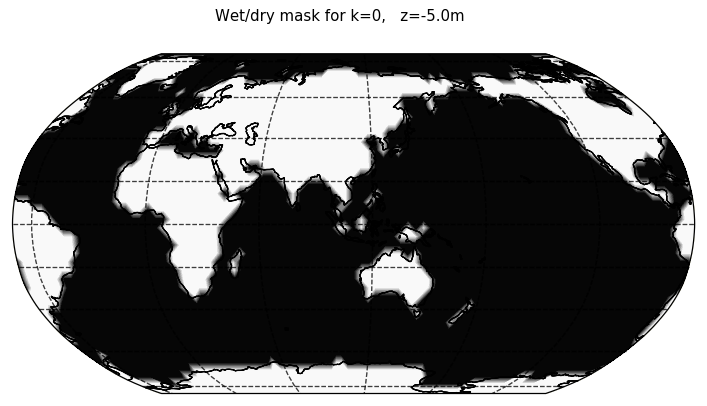

In [15]:
plt.figure(figsize=(12,5), dpi= 90)
k_level=0
tmp_plt = ecco_ds.SSH.isel(time=1)
tmp_plt = tmp_plt.where(ecco_ds.hFacC.isel(k=0) !=0)

ecco.plot_proj_to_latlon_grid(ecco_ds.XC,
                               ecco_ds.YC, 
                               ocean_mask[k_level,:], 
                               user_lon_0=110,
                               plot_type = 'contourf', dx=4,dy=4, cmap='binary');
# select out the model depth at k=1, round the number and convert to string.
z = str((np.round(ecco_ds.Z.values[k_level])))

plt.suptitle('Wet/dry mask for k=' + str(k_level) + ',   z=' + z + 'm');

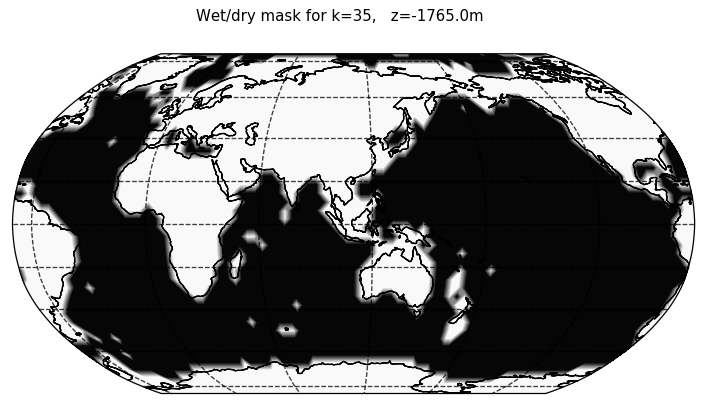

In [16]:
plt.figure(figsize=(12,5), dpi= 90)
k_level=35
tmp_plt = ecco_ds.SSH.isel(time=1)
tmp_plt = tmp_plt.where(ecco_ds.hFacC.isel(k=0) !=0)

ecco.plot_proj_to_latlon_grid(ecco_ds.XC,
                               ecco_ds.YC, 
                               ocean_mask[k_level,:], 
                               user_lon_0=110,
                               plot_type = 'contourf', dx=4,dy=4, cmap='binary');
# select out the model depth at k=1, round the number and convert to string.
z = str((np.round(ecco_ds.Z.values[k_level])))

plt.suptitle('Wet/dry mask for k=' + str(k_level) + ',   z=' + z + 'm');

To calculate $A_{\text{global ocean}}$ we must apply the surface wet/dry mask to $rA$.  

In [17]:
# Method 1: the array index method, []
#           select land_c at k index 0
total_ocean_area = np.sum(ecco_ds.rA*ocean_mask[0,:])

# these three methods give the same numerical result.  Here are 
# three alternative ways of printing the result
print ('total ocean surface area ( m^2) %d  ' % total_ocean_area.values)
print ('total ocean surface area (km^2) %d ' % (total_ocean_area.values/1.0e6))

# or in scientific notation with 2 decimal points
print ('total ocean surface area (km^2) %.2E' % (total_ocean_area.values/1.0e6))

total ocean surface area ( m^2) 358013844062208  
total ocean surface area (km^2) 358013844 
total ocean surface area (km^2) 3.58E+08


This compares favorable with *Global surface area of Earth's Oceans : approx 3.60 x $10^8$ $km^2$* from https://hypertextbook.com/facts/1997/EricCheng.shtml

##### Multiplication of DataArrays
You probably noticed that the multiplication of grid cell area with the land mask was done element by element.  One useful feature of `DataArrays` is that their dimensions are automatically lined up when doing binary operations.  Also, because *rA* and *ocean_mask* are both `DataArrays`, their inner product and their sums are also `DataArrays`.  

> Note:: *ocean_mask* has a depth (**k**) dimension while *rA* does not (horizontal model grid cell area does not change as a function of depth in ECCOv4).  As a result, when *rA* is multiplied with *ocean_mask* `xarray` **broadcasts** *rA* to all **k** levels.  The resulting matrix  inherits the **k** dimension from *ocean_mask*.

##### Another way of summing over `numpy` arrays

As *rA* and ocean both store `numpy` arrays, you can also calculate the sum of their product by invoking the `.sum()` command inherited in all `numpy arrays`:

In [18]:
total_ocean_area = (ecco_ds.rA*ocean_mask).isel(k=0).sum()
print 'total ocean surface area (km^2) ' + '%.2E' % (total_ocean_area.values/1e6)

total ocean surface area (km^2) 3.58E+08


#### Part2 : $SSH_{\text{global mean}}(t)$

The global mean *SSH* at each $t$ is given by,

$$SSH_{\text{global mean}}(t) = \frac{\sum_{i} SSH(i,t) \,\, A(i)}{A_{\text{global ocean}}}$$

One way of calculating this is to take advantage of `DataArray` coordinate labels and use its *.sum()* functionality to explicitly specify which dimensions to sum over:

In [19]:
# note no need to multiple RAC by land_c because SSH is nan over land
SSH_global_mean = (ecco_ds.SSH*ecco_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
SSH_global_mean

<xarray.DataArray (time: 365)>
dask.array<shape=(365,), dtype=float32, chunksize=(90,)>
Coordinates:
    iter     (time) int32 dask.array<shape=(365,), chunksize=(90,)>
  * time     (time) datetime64[ns] 2010-01-01T12:00:00 ... 2010-12-31T12:00:00
    k        int64 0
    Z        float32 -5.0
    PHrefC   float32 ...
    drF      float32 ...

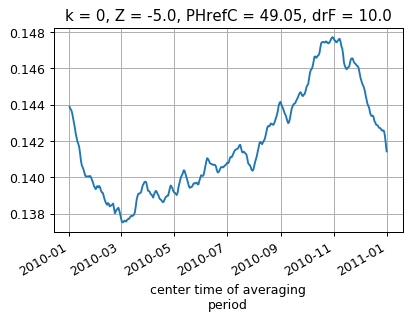

In [20]:
plt.figure(figsize=(5,3), dpi= 90)
SSH_global_mean.plot()
plt.grid()

Alternatively we can do the summation over the three non-time dimensions.  The time dimension of SSH is along the first dimension (axis) of the array, axis 0.

In [21]:
ecco_ds.SSH

<xarray.DataArray 'SSH' (time: 365, tile: 13, j: 90, i: 90)>
dask.array<shape=(365, 13, 90, 90), dtype=float32, chunksize=(90, 13, 90, 90)>
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (tile, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    YC       (tile, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    Depth    (tile, j, i) float32 ...
    rA       (tile, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    iter     (time) int32 dask.array<shape=(365,), chunksize=(90,)>
  * time     (time) datetime64[ns] 2010-01-01T12:00:00 ... 2010-12-31T12:00:00
Attributes:
    units:          m
    long_name:      Surface Height Anomaly adjusted with global steric height...
    standard_name:  sea_surface_height

In [22]:
# note no need to multiple RAC by land_c because SSH is nan over land
SSH_global_mean = np.sum(ecco_ds.SSH*ecco_ds.rA,axis=(1,2,3))/total_ocean_area
SSH_global_mean

<xarray.DataArray (time: 365)>
dask.array<shape=(365,), dtype=float32, chunksize=(90,)>
Coordinates:
    iter     (time) int32 dask.array<shape=(365,), chunksize=(90,)>
  * time     (time) datetime64[ns] 2010-01-01T12:00:00 ... 2010-12-31T12:00:00
    k        int64 0
    Z        float32 -5.0
    PHrefC   float32 ...
    drF      float32 ...

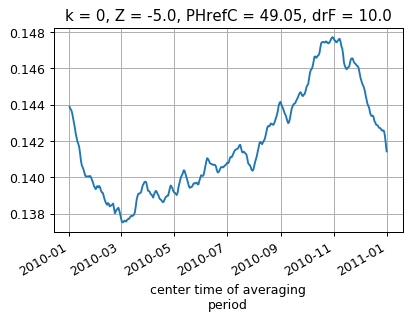

In [23]:
plt.figure(figsize=(5,3), dpi= 90)
SSH_global_mean.plot()
plt.grid()

Even though *SSH* has 3 dimensions (time, tile, j, i) and *rA* and *ocean_mask.isel(k=0)* have 2 (j,i), we can mulitply them. With `xarray` the element-by-element multiplication occurs over their common dimension.

The resulting $SSH_{global-mean}$ `DataArray` has a single dimension, time.

#### Part 3 : Plotting the global mean sea level time series:

Before we plot the global mean sea level curve let's remove its time-mean to make it global mean sea level anomaly (the absolute value has no meaning here anyway).

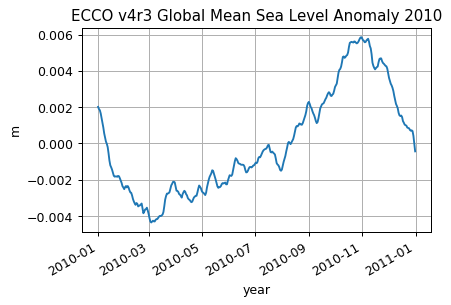

In [24]:
# Method 1: .mean() method of `DataArrays`
SSH_global_mean_anomaly = SSH_global_mean - SSH_global_mean.mean()

# Method 2: numpy's `mean` method 
SSH_global_mean_anomaly = SSH_global_mean - np.mean(SSH_global_mean)

plt.figure(figsize=(5,3), dpi= 90)
SSH_global_mean_anomaly.plot()
plt.grid()
plt.title('ECCO v4r3 Global Mean Sea Level Anomaly 2010');
plt.ylabel('m');
plt.xlabel('year');

### Mean Dynamic Topography

Mean dynamic topography is calculated as follows,

$MDT(i) = \frac{\sum_{t} SSH(i,t) - SSH_{\text{global mean}}(t)}{nt} $

Where $nt$ is the number of time records. 

For *MDT* we presere the spatial dimensions. Summation and averaging are over the time dimensions (axis 0).

In [25]:
## Two equivalent methods

# Method 1, specify the axis over which to average
MDT = np.mean(ecco_ds.SSH - SSH_global_mean,axis=0)

# Method 2, specify the coordinate label over which to average
MDT_B = (ecco_ds.SSH - SSH_global_mean).mean(dim=['time'])

# which can be verified using the '.equals()' method to compare Datasets and DataArrays
print(MDT.equals(MDT_B))

True


As expected, MDT has preserved its spatial dimensions:

In [26]:
MDT.dims

('tile', u'j', u'i')

Before plotting the MDT field remove its spatial mean since its spatial mean conveys no dynamically useful information.  

In [27]:
MDT_no_spatial_mean = MDT - MDT*ecco_ds.rA/total_ocean_area

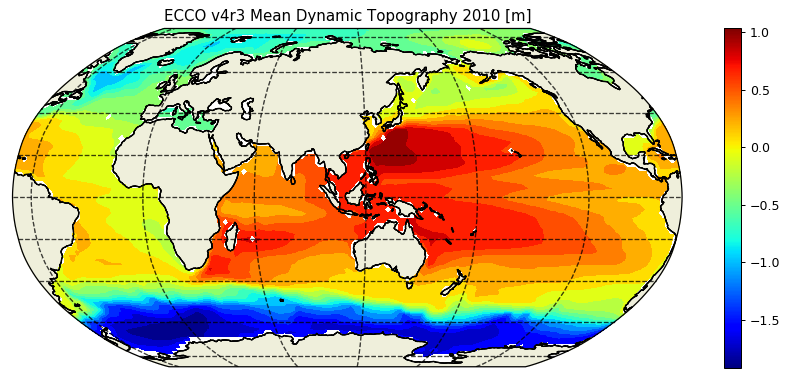

In [28]:
plt.figure(figsize=(12,5), dpi= 90)

# mask land points to Nan
MDT_no_spatial_mean = MDT_no_spatial_mean.where(ocean_mask[0,:] !=0)

ecco.plot_proj_to_latlon_grid(ecco_ds.XC, \
                              ecco_ds.YC, \
                              MDT_no_spatial_mean,\
                              user_lon_0=110,\
                              plot_type = 'contourf', \
                              show_colorbar=True,\
                              dx=2,dy=2);

plt.title('ECCO v4r3 Mean Dynamic Topography 2010 [m]');

### Spatial variations of sea level linear trends  

To calculate the linear trend for the each model point we will use on the `polyfit` function of `numpy`.  First, define a time variable in years for SSH.

In [29]:
ssh_flat = np.reshape(ecco_ds.SSH.values,[365, 13*90*90])
ssh_flat.shape

(365, 105300)

In [30]:
day_of_year = ((ecco_ds.time - ecco_ds.time[0])/86400e9).astype(int)
day_of_year

<xarray.DataArray 'time' (time: 365)>
array([  0,   1,   2, ..., 362, 363, 364])
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01T12:00:00 ... 2010-12-31T12:00:00

Next, reshape the four dimensional SSH field into two dimensions, time and space (t, i)

Now set all $SSH$ values that are 'nan' to zero because the polynominal fitting
routine can't handle nans,

In [31]:
ssh_flat[np.isnan(ssh_flat)]=0.0

Do the polynomial fitting, https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.polyfit.html

In [32]:
ssh_slope, ssh_intercept = np.polyfit(day_of_year, ssh_flat, 1)

# and reshape the slope result back to 13x90x90    
ssh_slope = np.reshape(ssh_slope, (13, 90,90))
ssh_slope_masked = np.where(ocean_mask[0,:] > 0, ssh_slope, np.nan)

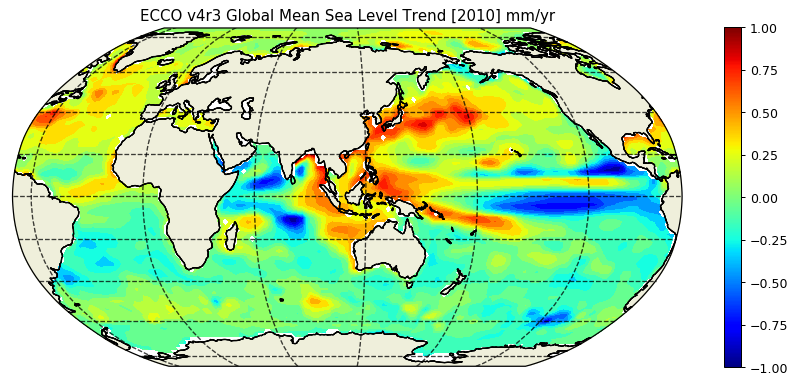

In [33]:
plt.figure(figsize=(12,5), dpi= 90)

ecco.plot_proj_to_latlon_grid(ecco_ds.XC, \
                              ecco_ds.YC, \
                              ssh_slope_masked*1e3,\
                              user_lon_0=110,\
                              plot_type = 'contourf', \
                              show_colorbar=True,\
                              cmin=-1, cmax=1,\
                              dx=2,dy=2);

# from m/yr to mm/year
plt.title('ECCO v4r3 Global Mean Sea Level Trend [2010] mm/yr');

### Spatial variations of sea level linear trends over two epochs 

Now we will repeat the last exercise but split the analysis into two 12 year epochs, Jan 1992 to 2003 and Jan 2004 to Dec 2015.

## Regional calculations with THETA

In [34]:
lat_bounds = np.logical_and(ecco_ds.YC >= -5, ecco_ds.YC <= 5)
lon_bounds = np.logical_and(ecco_ds.XC >= -170, ecco_ds.XC <= -120)

SST = ecco_ds.THETA

SST_masked=SST.where(np.logical_and(lat_bounds, lon_bounds))
#SST_masked

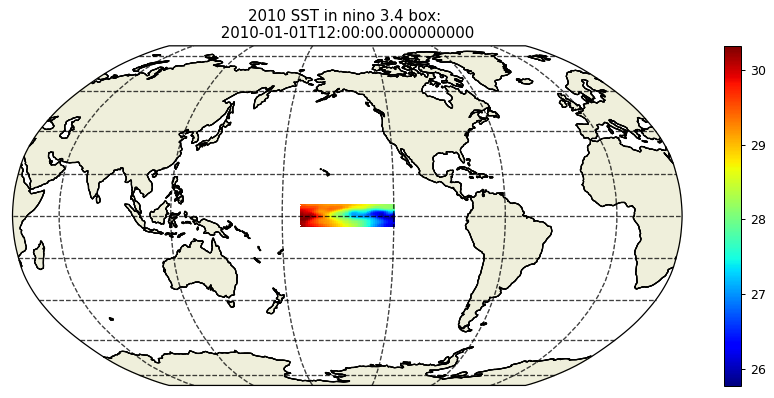

In [35]:
plt.figure(figsize=(12,5), dpi= 90)

ecco.plot_proj_to_latlon_grid(ecco_ds.XC, \
                              ecco_ds.YC, \
                              SST_masked[0,:],\
                              user_lon_0 = -145,\
                              show_colorbar=True);

plt.title('2010 SST in nino 3.4 box: \n %s ' % str(ecco_ds.time[0].values));

In [45]:
# Create the same mask for the grid cell area
rA_masked=ecco_ds.rA.where(np.logical_and(lat_bounds, lon_bounds));

# Calculate the area-weighted mean in the box
SST_masked_mean=(SST_masked*rA_masked).sum(dim=['tile','j','i'])/np.sum(rA_masked)

# Substract the temporal mean from the area-weighted mean to get a time series
SST_nino_34_anom = SST_masked_mean - np.mean(SST_masked_mean)

### Load up the Nino 3.4 index values from ESRL

In [43]:
# https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/Nino34/
# https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/Data/nino34.long.anom.data
# NINA34
# 5N-5S 170W-120W 
# HadISST 
#  Anomaly from 1981-2010
#  units=degC

nino_3p4_2010 = [1.43,1.18,1.07,0.56,-0.15,-0.62,-0.89,-1.33,-1.56,-1.65,-1.57,-1.63]

# create an array of month dates for plotting, from Jan 15 to Dec 15, 2010
import datetime
dt_array = np.array([datetime.datetime(2010, i, 15) for i in range(1,13)])
dt_array

array([datetime.datetime(2010, 1, 15, 0, 0),
       datetime.datetime(2010, 2, 15, 0, 0),
       datetime.datetime(2010, 3, 15, 0, 0),
       datetime.datetime(2010, 4, 15, 0, 0),
       datetime.datetime(2010, 5, 15, 0, 0),
       datetime.datetime(2010, 6, 15, 0, 0),
       datetime.datetime(2010, 7, 15, 0, 0),
       datetime.datetime(2010, 8, 15, 0, 0),
       datetime.datetime(2010, 9, 15, 0, 0),
       datetime.datetime(2010, 10, 15, 0, 0),
       datetime.datetime(2010, 11, 15, 0, 0),
       datetime.datetime(2010, 12, 15, 0, 0)], dtype=object)

### Plot the ECCOv4r3 and ESRL nino 3.4 index for 2010

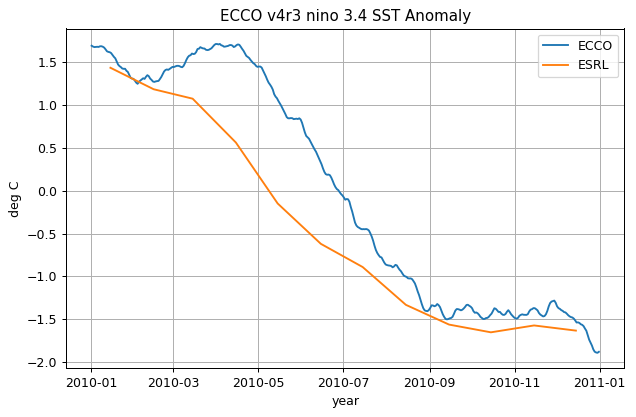

In [49]:
plt.figure(figsize=(8,5), dpi= 90)
plt.plot(SST_nino_34_anom.time, SST_nino_34_anom, dt_array, nino_3p4_2010)
plt.title('ECCO v4r3 nino 3.4 SST Anomaly');
plt.legend(('ECCO','ESRL'))
plt.ylabel('deg C');
plt.xlabel('year');
plt.grid()

### Show the nino 3.4 index from 2008-2016 for context

In [51]:
from IPython.display import Image
from IPython.core.display import HTML 

# http://www.climate.washington.edu/events/2016winter/
Image(url= "http://www.climate.washington.edu/events/2016winter/Fig1.png", width=600, height=200)

## Conclusion

You should now be familiar with doing some doing calculations using scalar quantities.